In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample

from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from PreprocessFcns import *

%matplotlib inline

sns.set_context('talk',font_scale=1)

In [39]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            ######
            
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

# Accelerometer and EMG comparisons

In [5]:
Data_accel = pd.read_hdf('Z:\CIS-PD Study\FeatureMatrix\Features_AllLocs_HP.h5')
Data_EMG = pd.read_csv('Z:CIS-PD Study\MotorTasks EMG Data.csv',index_col=0).iloc[:,6:]

Datafull = pd.DataFrame
Data_accel = Data_accel.reset_index(drop=True)
Data_EMG = Data_EMG.reset_index(drop=True)
Datafull = pd.concat((Data_accel.iloc[:,:6],Data_EMG,Data_accel.iloc[:,13]),axis=1)

In [6]:
Datafull.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,RMS0,mean0,var0,skew0,...,MAV9,RMS10,mean10,var10,skew10,kurt10,binen10,energy10,MAV10,flexor_digitorum__accel
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0122164607654984, 0.00664163061640281, 0.00..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.010626645669058962, 0.006257554464780335, 0..."
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.009801355639564385, 0.00597036114953965, 0...."
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.000058,0.000129,0.000009,0.399398,...,0.000002,1.818105e-08,4.014991e-09,9.088620e-07,-0.036244,1.759811,2.024107,2.064290e-09,6.495575e-07,"[0.012370743231278975, 0.006549813970182376, 0..."
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.011069607558498772, 0.006669541371605966, 0..."


In [7]:
s = 'flexor_digitorum__accel'
print('%s,discarded %d rows'%(s,sum(Datafull[s].apply(type) == float)))
Datafull = Datafull[Datafull[s].apply(type) != float]

s = 'Tremor'
print('%s,discarded %d rows'%(s,sum(np.isnan(Datafull[s]))))
Datafull = Datafull[~np.isnan(Datafull[s])]

s = Data_EMG.columns.values[6]
print('%s,discarded %d rows'%(s,sum(np.isnan(Datafull[s]))))
Datafull = Datafull[~np.isnan(Datafull[s])]

flexor_digitorum__accel,discarded 6358 rows
Tremor,discarded 3384 rows
energy0,discarded 18271 rows


In [8]:
def feature_unpack_forearm(Datafull):
    #unpack features
    colnames_accel =['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
           'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
           'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
           'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
           'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
           'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']
    colnames_accel =[i+' accel' for i in colnames_accel]

    sensor = 'flexor_digitorum__accel'
    
    Datafinal = pd.DataFrame()
    
    for i in range(len(Datafull)):
        F = Datafull[sensor].iloc[i]
        F = pd.DataFrame(data=F.reshape(-1,1).T,index=[i],columns=colnames_accel)
        Datafinal = pd.concat((Datafinal,F))
    Datafinal=Datafinal.reset_index(drop=True)
    Datafull=Datafull.reset_index(drop=True)
    Datafinal = pd.concat((Datafull.iloc[:,:94],Datafinal),axis=1)

    return Datafinal

In [9]:
Datafull = feature_unpack_forearm(Datafull)

In [10]:
Datafull.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,RMS0,mean0,var0,skew0,...,PSD_std accel,PSD_skew accel,PSD_kur accel,jerk_mean accel,jerk_std accel,jerk_skew accel,jerk_kur accel,Sen_X accel,Sen_Y accel,Sen_Z accel
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.000058,0.000129,0.000009,0.399398,...,0.001444,2.382094,5.333100,0.000575,0.054457,0.551808,1.459770,0.574293,0.741461,0.783992
1,1004,4 Weeks,left,Motor #2: Walking,0.0,0.0,0.000056,0.000124,0.000011,-0.347647,...,0.002467,3.798906,15.633740,-0.000238,0.057850,0.941721,3.168144,0.644744,0.786910,0.878338
2,1004,4 Weeks,left,Motor #2: Walking,0.0,0.0,0.000060,0.000134,0.000014,0.958786,...,0.001858,3.593627,13.813865,0.002097,0.046613,0.998875,3.229052,0.650181,0.715376,0.908934
3,1004,4 Weeks,left,Motor #2: Walking,0.0,0.0,0.000057,0.000126,0.000012,0.254498,...,0.002840,1.330189,0.418690,0.000635,0.057558,-0.139625,1.690948,0.622565,0.677374,0.750162
4,1004,4 Weeks,left,Motor #2: Walking,0.0,0.0,0.000053,0.000117,0.000013,0.216862,...,0.005875,1.849822,2.488761,-0.002750,0.065912,0.191875,2.691909,0.652863,0.642245,0.760753


## Leave One Subject Out

### Tremor

In [25]:
#LOSO EMG Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:94].as_matrix()
fnames = Data.iloc[:,6:94].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 4087/19605 = 0.21
Training Random Forest

Subj/Visit 0,prec=0.000,rec=0.000,Spec=0.991,auroc_train=1.000,auroc=0.589

Subj/Visit 1,prec=0.200,rec=0.001,Spec=0.996,auroc_train=1.000,auroc=0.581

Subj/Visit 2,prec=0.000,rec=0.000,Spec=0.998,auroc_train=1.000,auroc=0.524

Subj/Visit 3,prec=0.000,rec=0.000,Spec=0.994,auroc_train=1.000,auroc=0.451

Subj/Visit 4,prec=1.000,rec=0.029,Spec=1.000,auroc_train=1.000,auroc=0.582

Subj/Visit 5,prec=0.167,rec=0.005,Spec=0.993,auroc_train=1.000,auroc=0.583

Subj/Visit 6,prec=0.333,rec=0.005,Spec=0.995,auroc_train=1.000,auroc=0.544

Subj/Visit 7,prec=0.000,rec=0.000,Spec=0.994,auroc_train=1.000,auroc=0.453

Subj/Visit 8,prec=0.077,rec=0.021,Spec=0.990,auroc_train=1.000,auroc=0.557

Subj/Visit 9,prec=0.259,rec=0.019,Spec=0.962,auroc_train=1.000,auroc=0.543

Subj/Visit 10,prec=0.000,rec=0.000,Spec=0.992,auroc_train=1.000,auroc=0.442

Subj/Visit 11,prec=0.333,rec=0.010,Spec=0.994,auroc_train=1.000,auroc=0.508

Subj/Visit 12,prec=0.000,rec=0

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16,prec=0.000,rec=0.000,Spec=0.998,auroc_train=1.000,auroc=nan

Subj/Visit 17,prec=0.000,rec=0.000,Spec=0.989,auroc_train=1.000,auroc=0.378

Subj/Visit 18,prec=0.857,rec=0.023,Spec=0.986,auroc_train=1.000,auroc=0.548

Subj/Visit 19,prec=1.000,rec=0.002,Spec=1.000,auroc_train=1.000,auroc=0.450
f1_test=0.013+/-0.017, prec=0.225+/-0.326, rec=0.007+/-0.009, auprc=0.243+/-0.248, auroc=0.492+/-0.081
Elapsed time = 2.479 min


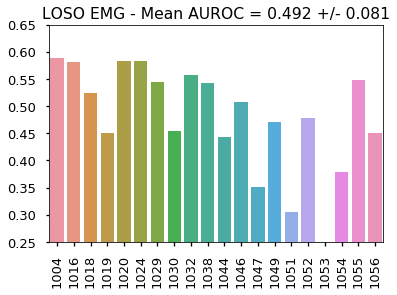

In [29]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOEMG.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.25,0.65])
plt.title('LOSO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOEMG.png',format='png',dpi=1000)

In [30]:
#LOSO Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,94:].as_matrix()
fnames = Data.iloc[:,94:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 4087/19605 = 0.21
Training Random Forest

Subj/Visit 0,prec=0.286,rec=0.130,Spec=0.957,auroc_train=1.000,auroc=0.783

Subj/Visit 1,prec=0.814,rec=0.058,Spec=0.988,auroc_train=1.000,auroc=0.715

Subj/Visit 2,prec=0.618,rec=0.300,Spec=0.986,auroc_train=1.000,auroc=0.868

Subj/Visit 3,prec=0.195,rec=0.140,Spec=0.973,auroc_train=1.000,auroc=0.674

Subj/Visit 4,prec=0.778,rec=0.400,Spec=0.964,auroc_train=1.000,auroc=0.818

Subj/Visit 5,prec=0.392,rec=0.105,Spec=0.954,auroc_train=1.000,auroc=0.667

Subj/Visit 6,prec=0.570,rec=0.206,Spec=0.928,auroc_train=1.000,auroc=0.707

Subj/Visit 7,prec=0.556,rec=0.510,Spec=0.980,auroc_train=1.000,auroc=0.939

Subj/Visit 8,prec=0.553,rec=0.542,Spec=0.983,auroc_train=1.000,auroc=0.892

Subj/Visit 9,prec=0.781,rec=0.202,Spec=0.960,auroc_train=1.000,auroc=0.751

Subj/Visit 10,prec=0.611,rec=0.489,Spec=0.980,auroc_train=1.000,auroc=0.942

Subj/Visit 11,prec=0.810,rec=0.054,Spec=0.996,auroc_train=1.000,auroc=0.716

Subj/Visit 12,prec=0.100,rec=0

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16,prec=0.000,rec=0.000,Spec=0.968,auroc_train=1.000,auroc=nan

Subj/Visit 17,prec=0.143,rec=0.714,Spec=0.973,auroc_train=1.000,auroc=0.975

Subj/Visit 18,prec=0.945,rec=0.161,Spec=0.965,auroc_train=1.000,auroc=0.684

Subj/Visit 19,prec=0.958,rec=0.219,Spec=0.961,auroc_train=1.000,auroc=0.682
f1_test=0.277+/-0.164, prec=0.503+/-0.303, rec=0.269+/-0.198, auprc=0.455+/-0.242, auroc=0.792+/-0.114
Elapsed time = 1.569 min


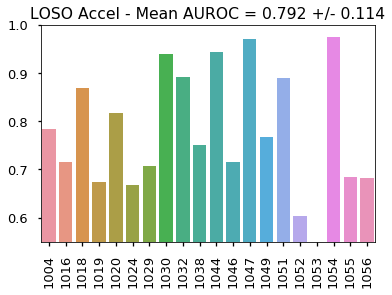

In [33]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOAccel.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.55,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOAccel.png',format='png',dpi=1000)

In [41]:
#LOSO Combined EMG and Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:].as_matrix()
fnames = Data.iloc[:,6:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 4087/19605 = 0.21
Training Random Forest

Subj/Visit 0,prec=0.378,rec=0.185,Spec=0.960,auroc_train=1.000,auroc=0.785

Subj/Visit 1,prec=0.724,rec=0.025,Spec=0.992,auroc_train=1.000,auroc=0.661

Subj/Visit 2,prec=0.556,rec=0.143,Spec=0.991,auroc_train=1.000,auroc=0.851

Subj/Visit 3,prec=0.059,rec=0.018,Spec=0.987,auroc_train=1.000,auroc=0.638

Subj/Visit 4,prec=0.875,rec=0.200,Spec=0.991,auroc_train=1.000,auroc=0.807

Subj/Visit 5,prec=0.353,rec=0.063,Spec=0.967,auroc_train=1.000,auroc=0.663

Subj/Visit 6,prec=0.610,rec=0.172,Spec=0.949,auroc_train=1.000,auroc=0.687

Subj/Visit 7,prec=0.528,rec=0.388,Spec=0.983,auroc_train=1.000,auroc=0.908

Subj/Visit 8,prec=0.370,rec=0.354,Spec=0.976,auroc_train=1.000,auroc=0.919

Subj/Visit 9,prec=0.644,rec=0.102,Spec=0.960,auroc_train=1.000,auroc=0.691

Subj/Visit 10,prec=0.462,rec=0.267,Spec=0.980,auroc_train=1.000,auroc=0.910

Subj/Visit 11,prec=0.720,rec=0.058,Spec=0.993,auroc_train=1.000,auroc=0.671

Subj/Visit 12,prec=0.060,rec=0

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16,prec=0.000,rec=0.000,Spec=0.988,auroc_train=1.000,auroc=nan

Subj/Visit 17,prec=0.043,rec=0.286,Spec=0.960,auroc_train=1.000,auroc=0.913

Subj/Visit 18,prec=0.958,rec=0.128,Spec=0.979,auroc_train=1.000,auroc=0.699

Subj/Visit 19,prec=0.923,rec=0.116,Spec=0.961,auroc_train=1.000,auroc=0.636
f1_test=0.179+/-0.125, prec=0.460+/-0.318, rec=0.159+/-0.135, auprc=0.398+/-0.257, auroc=0.762+/-0.113
Elapsed time = 2.738 min


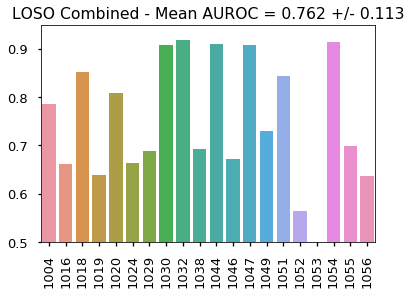

In [42]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOCombined.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,0.95])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOCombined.png',format='png',dpi=1000)

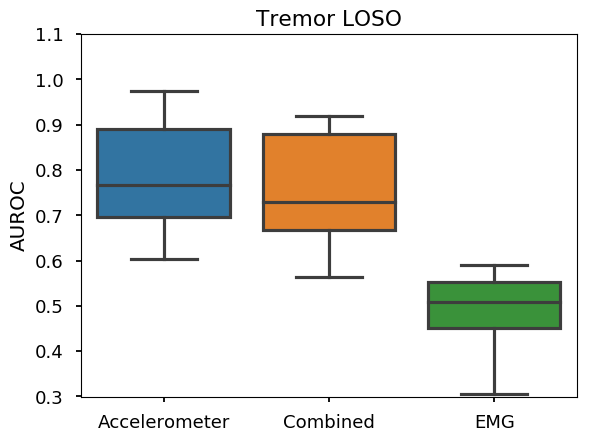

In [107]:
resultsEMG = np.load('Results/resultsTremorLOSOEMG.npy')
resultsAccel = np.load('Results/resultsTremorLOSOAccel.npy')
resultsCombined = np.load('Results/resultsTremorLOSOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Tremor LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOSO.png',format='png',dpi=1000)

### Bradykinesia

In [56]:
#LOSO EMG Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:94].as_matrix()
fnames = Data.iloc[:,6:94].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 8127/15532 = 0.52
Training Random Forest

Subj/Visit 0,prec=0.337,rec=0.515,Spec=0.467,auroc_train=1.000,auroc=0.522

Subj/Visit 1,prec=0.937,rec=0.488,Spec=0.531,auroc_train=1.000,auroc=0.516

Subj/Visit 2,prec=0.633,rec=0.528,Spec=0.637,auroc_train=1.000,auroc=0.622

Subj/Visit 3,prec=0.360,rec=0.689,Spec=0.316,auroc_train=1.000,auroc=0.496

Subj/Visit 4,prec=0.553,rec=0.636,Spec=0.333,auroc_train=1.000,auroc=0.482

Subj/Visit 5,prec=0.693,rec=0.664,Spec=0.576,auroc_train=1.000,auroc=0.630

Subj/Visit 6,prec=0.646,rec=0.623,Spec=0.453,auroc_train=1.000,auroc=0.565

Subj/Visit 7,prec=0.484,rec=0.582,Spec=0.346,auroc_train=1.000,auroc=0.423

Subj/Visit 8,prec=0.883,rec=0.340,Spec=0.626,auroc_train=1.000,auroc=0.481

Subj/Visit 9,prec=0.350,rec=0.455,Spec=0.590,auroc_train=1.000,auroc=0.547

Subj/Visit 10,prec=0.422,rec=0.516,Spec=0.497,auroc_train=1.000,auroc=0.503

Subj/Visit 11,prec=0.435,rec=0.694,Spec=0.348,auroc_train=1.000,auroc=0.515

Subj/Visit 12,prec=0.111

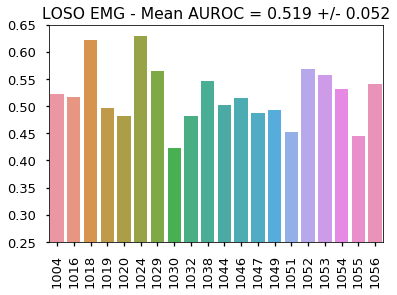

In [57]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOEMG.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.25,0.65])
plt.title('LOSO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOEMG.png',format='png',dpi=1000)

In [80]:
#LOSO Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,94:].as_matrix()
fnames = Data.iloc[:,94:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 8127/15532 = 0.52
Training Random Forest

Subj/Visit 0,prec=0.342,rec=0.476,Spec=0.517,auroc_train=1.000,auroc=0.513

Subj/Visit 1,prec=0.979,rec=0.694,Spec=0.786,auroc_train=1.000,auroc=0.807

Subj/Visit 2,prec=0.685,rec=0.803,Spec=0.562,auroc_train=1.000,auroc=0.733

Subj/Visit 3,prec=0.454,rec=0.813,Spec=0.454,auroc_train=1.000,auroc=0.706

Subj/Visit 4,prec=0.727,rec=0.606,Spec=0.706,auroc_train=1.000,auroc=0.653

Subj/Visit 5,prec=0.743,rec=0.568,Spec=0.717,auroc_train=1.000,auroc=0.716

Subj/Visit 6,prec=0.694,rec=0.787,Spec=0.444,auroc_train=1.000,auroc=0.640

Subj/Visit 7,prec=0.716,rec=0.723,Spec=0.697,auroc_train=1.000,auroc=0.795

Subj/Visit 8,prec=0.949,rec=0.587,Spec=0.738,auroc_train=1.000,auroc=0.712

Subj/Visit 9,prec=0.339,rec=0.355,Spec=0.664,auroc_train=1.000,auroc=0.533

Subj/Visit 10,prec=0.494,rec=0.500,Spec=0.635,auroc_train=1.000,auroc=0.618

Subj/Visit 11,prec=0.566,rec=0.612,Spec=0.660,auroc_train=1.000,auroc=0.680

Subj/Visit 12,prec=0.250

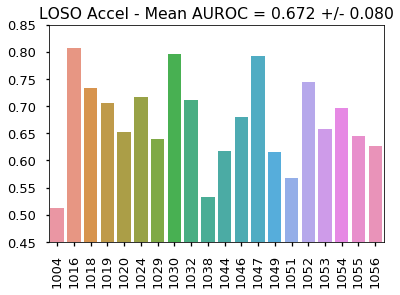

In [82]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOAccel.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.45,0.85])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOAccel.png',format='png',dpi=1000)

In [60]:
#LOSO Combined EMG and Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:].as_matrix()
fnames = Data.iloc[:,6:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 8127/15532 = 0.52
Training Random Forest

Subj/Visit 0,prec=0.390,rec=0.624,Spec=0.485,auroc_train=1.000,auroc=0.531

Subj/Visit 1,prec=0.984,rec=0.741,Spec=0.827,auroc_train=1.000,auroc=0.882

Subj/Visit 2,prec=0.687,rec=0.747,Spec=0.597,auroc_train=1.000,auroc=0.754

Subj/Visit 3,prec=0.441,rec=0.761,Spec=0.460,auroc_train=1.000,auroc=0.664

Subj/Visit 4,prec=0.789,rec=0.682,Spec=0.765,auroc_train=1.000,auroc=0.726

Subj/Visit 5,prec=0.703,rec=0.576,Spec=0.651,auroc_train=1.000,auroc=0.679

Subj/Visit 6,prec=0.693,rec=0.772,Spec=0.450,auroc_train=1.000,auroc=0.643

Subj/Visit 7,prec=0.744,rec=0.819,Spec=0.702,auroc_train=1.000,auroc=0.806

Subj/Visit 8,prec=0.962,rec=0.401,Spec=0.869,auroc_train=1.000,auroc=0.719

Subj/Visit 9,prec=0.373,rec=0.374,Spec=0.694,auroc_train=1.000,auroc=0.594

Subj/Visit 10,prec=0.451,rec=0.556,Spec=0.517,auroc_train=1.000,auroc=0.594

Subj/Visit 11,prec=0.535,rec=0.698,Spec=0.560,auroc_train=1.000,auroc=0.666

Subj/Visit 12,prec=0.160

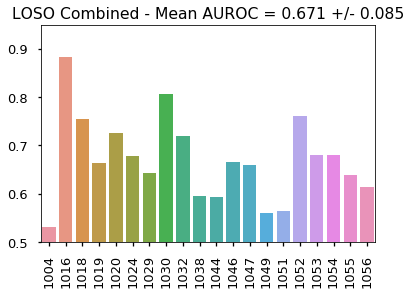

In [61]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOCombined.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,0.95])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOCombined.png',format='png',dpi=1000)

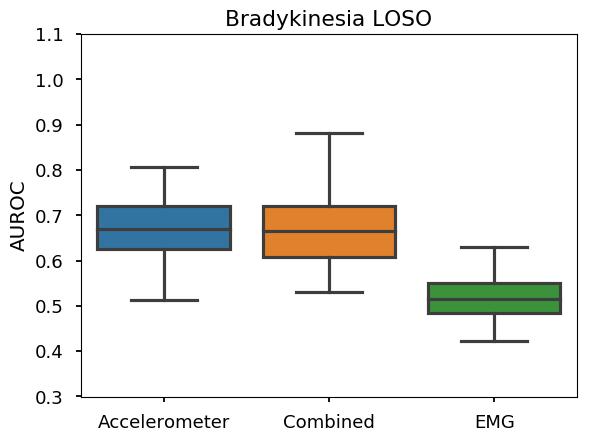

In [108]:
resultsEMG = np.load('Results/resultsBradykinesiaLOSOEMG.npy')
resultsAccel = np.load('Results/resultsBradykinesiaLOSOAccel.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOSOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOSO.png',format='png',dpi=1000)

## Leave One Visit Out

### Tremor

In [101]:
#LOVO EMG Tremor

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:94]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

Subject 1004
Training Random Forest

Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.501


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less

only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=0.992,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan

Subj/Visit 3,prec=0.000,rec=0.000,Spec=0.989,auroc_train=1.000,auroc=0.386
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan

Subj/Visit 6,prec=0.000,rec=0.000,Spec=0.981,auroc_train=1.000,auroc=0.588
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.298+/-0.301, auroc=0.492+/-0.083
Subject 1016
Training Random Forest

Subj/Visit 0,prec=0.779,rec=0.779,Spec=0.782,auroc_train=1.000,auroc=0.844

Subj/Visit 1,prec=0.813,rec=0.719,Spec=0.777,auroc_train=1.000,auroc=0.819

Subj/Visit 2,prec=0.793,rec=0.681,Spec=0.814,auroc_train=1.000,auroc=0.801

Subj/Visit 3,prec=0.840,rec=0.734,Spec=0.833,auroc_train=1.000,auroc=0.865

Subj/Visit 4,prec=0.841,rec=0.799,Spec=0.809,auroc_train=1.000,auroc=0.872

Subj/Visit 5,prec=0.786,rec=0.523,Spec=0.798,auroc_train=1.000,auroc=0.784


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6,prec=0.000,rec=0.000,Spec=0.472,auroc_train=1.000,auroc=nan
f1_test=0.644+/-0.269, prec=0.693+/-0.284, rec=0.605+/-0.261, auprc=0.815+/-0.040, auroc=0.831+/-0.032
Subject 1018
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.550


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.593


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.471


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.577


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.729


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.794


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.408
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.091+/-0.047, auroc=0.589+/-0.125
Subject 1019
Training Random Forest

Subj/Visit 0,prec=0.000,rec=0.000,Spec=0.994,auroc_train=1.000,auroc=0.516


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.756


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.924


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.885


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.712


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.612


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.589
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.077+/-0.043, auroc=0.713+/-0.141
Subject 1020
Subject 1024
Training Random Forest

Subj/Visit 0,prec=0.857,rec=0.176,Spec=0.978,auroc_train=1.000,auroc=0.664

Subj/Visit 1,prec=0.286,rec=0.200,Spec=0.951,auroc_train=1.000,auroc=0.522

Subj/Visit 2,prec=0.095,rec=0.333,Spec=0.842,auroc_train=1.000,auroc=0.669

Subj/Visit 3,prec=0.571,rec=0.057,Spec=0.941,auroc_train=1.000,auroc=0.734

Subj/Visit 4,prec=0.273,rec=0.231,Spec=0.920,auroc_train=1.000,auroc=0.813
only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=0.845,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 6,prec=0.583,rec=0.292,Spec=0.950,auroc_train=1.000,auroc=0.867
f1_test=0.203+/-0.119, prec=0.381+/-0.281, rec=0.184+/-0.111, auprc=0.406+/-0.253, auroc=0.712+/-0.112
Subject 1029
Training Random Forest

Subj/Visit 0,prec=1.000,rec=0.125,Spec=1.000,auroc_train=1.000,auroc=0.719

Subj/Visit 1,prec=0.062,rec=0.118,Spec=0.784,auroc_train=1.000,auroc=0.389

Subj/Visit 2,prec=0.051,rec=0.143,Spec=0.798,auroc_train=1.000,auroc=0.471

Subj/Visit 3,prec=0.560,rec=0.184,Spec=0.855,auroc_train=1.000,auroc=0.511

Subj/Visit 4,prec=0.393,rec=0.324,Spec=0.874,auroc_train=1.000,auroc=0.650

Subj/Visit 5,prec=0.211,rec=0.121,Spec=0.871,auroc_train=1.000,auroc=0.601

Subj/Visit 6,prec=0.524,rec=0.126,Spec=0.902,auroc_train=1.000,auroc=0.584
f1_test=0.196+/-0.094, prec=0.400+/-0.310, rec=0.163+/-0.069, auprc=0.387+/-0.256, auroc=0.561+/-0.104
Subject 1030
Training Random Forest

Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.802


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.691

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.567


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-pack


Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.879

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.586


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.236

Subj/Visit 6,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.607
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.079+/-0.041, auroc=0.624+/-0.191
Subject 1032
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.578

Subj/Visit 1,prec=0.000,rec=0.000,Spec=0.993,auroc_train=1.000,auroc=0.690


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.792


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.279


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.476


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.937

Subj/Visit 6,prec=0.000,rec=0.000,Spec=0.996,auroc_train=1.000,auroc=0.513
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.058+/-0.047, auroc=0.609+/-0.201
Subject 1038
Training Random Forest

Subj/Visit 0,prec=0.889,rec=0.571,Spec=0.929,auroc_train=1.000,auroc=0.743

Subj/Visit 1,prec=0.702,rec=0.702,Spec=0.857,auroc_train=1.000,auroc=0.728

Subj/Visit 2,prec=0.674,rec=0.689,Spec=0.808,auroc_train=1.000,auroc=0.745

Subj/Visit 3,prec=0.618,rec=0.472,Spec=0.672,auroc_train=1.000,auroc=0.567

Subj/Visit 4,prec=0.727,rec=0.615,Spec=0.845,auroc_train=1.000,auroc=0.731

Subj/Visit 5,prec=0.892,rec=0.717,Spec=0.950,auroc_train=1.000,auroc=0.894

Subj/Visit 6,prec=0.651,rec=0.538,Spec=0.800,auroc_train=1.000,auroc=0.648
f1_test=0.667+/-0.077, prec=0.736+/-0.103, rec=0.615+/-0.086, auprc=0.694+/-0.105, auroc=0.722+/-0.093
Subject 1044
Training Random Forest

Subj/Visit 0,prec=0.000,rec=0.000,Spe

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.667

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.789


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.455

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.655


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.636

Subj/Visit 6,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.679
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.091+/-0.018, auroc=0.643+/-0.092
Subject 1046
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0,prec=0.100,rec=0.040,Spec=0.944,auroc_train=1.000,auroc=0.614

Subj/Visit 1,prec=0.533,rec=0.163,Spec=0.956,auroc_train=1.000,auroc=0.771

Subj/Visit 2,prec=0.333,rec=0.219,Spec=0.905,auroc_train=1.000,auroc=0.714

Subj/Visit 3,prec=0.368,rec=0.219,Spec=0.915,auroc_train=1.000,auroc=0.686

Subj/Visit 4,prec=0.750,rec=0.259,Spec=0.966,auroc_train=1.000,auroc=0.839

Subj/Visit 5,prec=0.778,rec=0.230,Spec=0.974,auroc_train=1.000,auroc=0.799

Subj/Visit 6,prec=0.615,rec=0.143,Spec=0.962,auroc_train=1.000,auroc=0.691
f1_test=0.260+/-0.098, prec=0.497+/-0.226, rec=0.182+/-0.069, auprc=0.425+/-0.158, auroc=0.730+/-0.071
Subject 1047
Training Random Forest

Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.447


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan

Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.453


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.012+/-0.008, auroc=0.450+/-0.003
Subject 1049
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 0,prec=0.435,rec=0.307,Spec=0.693,auroc_train=1.000,auroc=0.460

Subj/Visit 1,prec=0.595,rec=0.379,Spec=0.691,auroc_train=1.000,auroc=0.564

Subj/Visit 2,prec=0.789,rec=0.273,Spec=0.818,auroc_train=1.000,auroc=0.519

Subj/Visit 3,prec=0.255,rec=0.500,Spec=0.752,auroc_train=1.000,auroc=0.658

Subj/Visit 4,prec=0.300,rec=0.281,Spec=0.864,auroc_train=1.000,auroc=0.657

Subj/Visit 5,prec=0.367,rec=0.159,Spec=0.846,auroc_train=1.000,auroc=0.582

Subj/Visit 6,prec=0.489,rec=0.211,Spec=0.718,auroc_train=1.000,auroc=0.518
f1_test=0.339+/-0.074, prec=0.462+/-0.171, rec=0.301+/-0.104, auprc=0.457+/-0.173, auroc=0.565+/-0.069
Subject 1051
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\s


Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.517


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=0.990,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=0.994,auroc_train=1.000,auroc=nan

Subj/Visit 3,prec=0.500,rec=0.037,Spec=0.994,auroc_train=1.000,auroc=0.432


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=0.994,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\

only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.011+/-0.026, prec=0.083+/-0.186, rec=0.006+/-0.014, auprc=0.295+/-0.098, auroc=0.474+/-0.043
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1054
Training Random Forest
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:91: Runti

only 1 class in test data - cannot compute roc curve

Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest

Subj/Visit 0,prec=0.925,rec=0.943,Spec=0.000,auroc_train=1.000,auroc=0.176

Subj/Visit 1,prec=0.664,rec=0.924,Spec=0.000,auroc_train=1.000,auroc=0.276

Subj/Visit 2,prec=0.544,rec=0.974,Spec=0.000,auroc_train=1.000,auroc=0.258

Subj/Visit 3,prec=0.886,rec=0.969,Spec=0.000,auroc_train=1.000,auroc=0.431

Subj/Visit 4,prec=0.753,rec=0.986,Spec=0.000,auroc_train=1.000,auroc=0.336

Subj/Visit 5,prec=0.978,rec=0.840,Spec=0.000,auroc_train=1.000,auroc=0.274
f1_test=0.848+/-0.086, prec=0.792+/-0.153, rec=0.939+/-0.049, auprc=0.721+/-0.196, auroc=0.292+/-0.078
Subject 1056
Training Random Forest

Subj/Visit 0,prec=0

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5,prec=0.917,rec=0.982,Spec=0.091,auroc_train=1.000,auroc=0.598
f1_test=0.800+/-0.220, prec=0.742+/-0.297, rec=0.975+/-0.026, auprc=0.743+/-0.317, auroc=0.566+/-0.065


C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


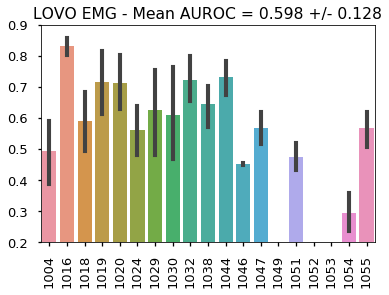

In [102]:
results = res_all.auroc.values
np.save('Results/resultsTremorLOVOEMG.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    tremor_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.2,0.9])

plt.savefig('Results/resultsTremorLOVOEMG.png',format='png',dpi=1000)

In [103]:
#LOVO Accelerometer Tremor

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,94:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

Subject 1004
Training Random Forest

Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.655


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 3,prec=1.000,rec=0.444,Spec=1.000,auroc_train=1.000,auroc=0.949
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan

Subj/Visit 6,prec=0.000,rec=0.000,Spec=0.972,auroc_train=1.000,auroc=0.837
f1_test=0.088+/-0.215, prec=0.143+/-0.350, rec=0.063+/-0.156, auprc=0.614+/-0.290, auroc=0.814+/-0.121
Subject 1016
Training Random Forest

Subj/Visit 0,prec=0.819,rec=0.779,Spec=0.831,auroc_train=1.000,auroc=0.878

Subj/Visit 1,prec=0.881,rec=0.849,Spec=0.845,auroc_train=1.000,auroc=0.916

Subj/Visit 2,prec=0.859,rec=0.815,Spec=0.860,auroc_train=1.000,auroc=0.913

Subj/Visit 3,prec=0.897,rec=0.727,Spec=0.900,auroc_train=1.000,auroc=0.917

Subj/Visit 4,prec=0.862,rec=0.899,Spec=0.818,auroc_train=1.000,auroc=0.916

Subj/Visit 5,prec=0.904,rec=0.852,Spec=0.872,auroc_train=1.000,auroc=0.922


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6,prec=0.000,rec=0.000,Spec=0.465,auroc_train=1.000,auroc=nan
f1_test=0.723+/-0.297, prec=0.746+/-0.306, rec=0.703+/-0.292, auprc=0.911+/-0.019, auroc=0.910+/-0.015
Subject 1018
Training Random Forest

Subj/Visit 0,prec=1.000,rec=0.250,Spec=1.000,auroc_train=1.000,auroc=0.798

Subj/Visit 1,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 2,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 3,prec=1.000,rec=0.375,Spec=1.000,auroc_train=1.000,auroc=0.909

Subj/Visit 4,prec=1.000,rec=0.250,Spec=1.000,auroc_train=1.000,auroc=0.773

Subj/Visit 5,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 6,prec=1.000,rec=0.889,Spec=1.000,auroc_train=1.000,auroc=1.000
f1_test=0.755+/-0.270, prec=1.000+/-0.000, rec=0.681+/-0.341, auprc=0.800+/-0.242, auroc=0.926+/-0.094
Subject 1019
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.479

Subj/Visit 1,prec=1.000,rec=0.667,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 2,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 3,prec=0.000,rec=0.000,Spec=0.972,auroc_train=1.000,auroc=0.865

Subj/Visit 4,prec=0.000,rec=0.000,Spec=0.995,auroc_train=1.000,auroc=0.978

Subj/Visit 5,prec=1.000,rec=0.500,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 6,prec=1.000,rec=0.100,Spec=1.000,auroc_train=1.000,auroc=0.687
f1_test=0.378+/-0.399, prec=0.571+/-0.495, rec=0.324+/-0.372, auprc=0.572+/-0.387, auroc=0.858+/-0.188
Subject 1020
Subject 1024
Training Random Forest

Subj/Visit 0,prec=1.000,rec=0.029,Spec=1.000,auroc_train=1.000,auroc=0.856

Subj/Visit 1,prec=0.286,rec=0.200,Spec=0.951,auroc_train=1.000,auroc=0.712

Subj/Visit 2,prec=0.067,rec=0.167,Spec=0.883,auroc_train=1.000,auroc=0.778

Subj/Visit 3,prec=0.889,rec=0.114,Spec=0.980,auroc_train=1.000,auroc=0.705

Subj/Visit 

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=0.971,auroc_train=1.000,auroc=nan

Subj/Visit 6,prec=0.500,rec=0.125,Spec=0.970,auroc_train=1.000,auroc=0.777
f1_test=0.139+/-0.082, prec=0.423+/-0.363, rec=0.113+/-0.068, auprc=0.403+/-0.288, auroc=0.762+/-0.051
Subject 1029
Training Random Forest

Subj/Visit 0,prec=0.967,rec=0.259,Spec=0.981,auroc_train=1.000,auroc=0.860

Subj/Visit 1,prec=0.350,rec=0.824,Spec=0.813,auroc_train=1.000,auroc=0.849

Subj/Visit 2,prec=0.101,rec=0.714,Spec=0.514,auroc_train=1.000,auroc=0.622

Subj/Visit 3,prec=0.850,rec=0.224,Spec=0.961,auroc_train=1.000,auroc=0.720

Subj/Visit 4,prec=0.606,rec=0.588,Spec=0.904,auroc_train=1.000,auroc=0.889

Subj/Visit 5,prec=0.536,rec=0.455,Spec=0.888,auroc_train=1.000,auroc=0.786

Subj/Visit 6,prec=0.625,rec=0.172,Spec=0.912,auroc_train=1.000,auroc=0.670
f1_test=0.399+/-0.133, prec=0.576+/-0.270, rec=0.462+/-0.237, auprc=0.585+/-0.227, auroc=0.771+/-0.095
Subject 1030
Training R

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.807

Subj/Visit 2,prec=1.000,rec=0.167,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 3,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 4,prec=1.000,rec=0.300,Spec=1.000,auroc_train=1.000,auroc=0.990

Subj/Visit 5,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 6,prec=0.600,rec=1.000,Spec=0.968,auroc_train=1.000,auroc=0.985
f1_test=0.627+/-0.358, prec=0.800+/-0.355, rec=0.610+/-0.407, auprc=0.875+/-0.176, auroc=0.968+/-0.066
Subject 1032
Training Random Forest

Subj/Visit 0,prec=0.500,rec=0.250,Spec=0.988,auroc_train=1.000,auroc=0.831

Subj/Visit 1,prec=1.000,rec=0.500,Spec=1.000,auroc_train=1.000,auroc=0.875

Subj/Visit 2,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 3,prec=1.000,rec=0.214,Spec=1.000,auroc_train=1.000,auroc=0.525

Subj/Visit 4,prec=0.286,rec=1.000,Spec=0.970,auroc_train=1.000,auroc=0.999

Subj/Visit 5,prec=1.000,

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan

Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.983
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.428+/-0.365, auroc=0.972+/-0.011
Subject 1049
Training Random Forest

Subj/Visit 0,prec=0.750,rec=0.682,Spec=0.825,auroc_train=1.000,auroc=0.844

Subj/Visit 1,prec=1.000,rec=0.621,Spec=1.000,auroc_train=1.000,auroc=0.921

Subj/Visit 2,prec=1.000,rec=0.582,Spec=1.000,auroc_train=1.000,auroc=0.948

Subj/Visit 3,prec=0.483,rec=0.538,Spec=0.902,auroc_train=1.000,auroc=0.794

Subj/Visit 4,prec=0.614,rec=0.844,Spec=0.890,auroc_train=1.000,auroc=0.936

Subj/Visit 5,prec=0.704,rec=0.551,Spec=0.870,auroc_train=1.000,auroc=0.824

Subj/Visit 6,prec=0.798,rec=0.615,Spec=0.800,auroc_train=1.000,auroc=0.804
f1_test=0.678+/-0.081, prec=0.764+/-0.176, rec=0.633+/-0.097, auprc=0.795+/-0.161, auroc=0.867+/-0.061
Subject 1051
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visi

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda

only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training Random Forest

Subj/Visit 0,prec=1.000,rec=0.014,Spec=1.000,auroc_train=1.000,auroc=0.671


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\User

only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=0.990,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=0.994,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.745
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:83: Runti

only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.005+/-0.010, prec=0.167+/-0.373, rec=0.002+/-0.005, auprc=0.361+/-0.097, auroc=0.708+/-0.037
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1054
Training Random Forest
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:91: Runti


Subj/Visit 0,prec=0.937,rec=0.990,Spec=0.125,auroc_train=1.000,auroc=0.772

Subj/Visit 1,prec=0.695,rec=0.924,Spec=0.135,auroc_train=1.000,auroc=0.525

Subj/Visit 2,prec=0.543,rec=0.921,Spec=0.048,auroc_train=1.000,auroc=0.606

Subj/Visit 3,prec=0.908,rec=0.927,Spec=0.250,auroc_train=1.000,auroc=0.818

Subj/Visit 4,prec=0.795,rec=0.986,Spec=0.217,auroc_train=1.000,auroc=0.826

Subj/Visit 5,prec=0.978,rec=0.830,Spec=0.000,auroc_train=1.000,auroc=0.767
f1_test=0.856+/-0.093, prec=0.809+/-0.152, rec=0.930+/-0.053, auprc=0.884+/-0.125, auroc=0.719+/-0.113
Subject 1056
Training Random Forest

Subj/Visit 0,prec=0.915,rec=0.866,Spec=0.250,auroc_train=1.000,auroc=0.672

Subj/Visit 1,prec=0.303,rec=1.000,Spec=0.013,auroc_train=1.000,auroc=0.630

Subj/Visit 2,prec=0.344,rec=0.786,Spec=0.192,auroc_train=1.000,auroc=0.558

Subj/Visit 3,prec=0.983,rec=0.991,Spec=0.000,auroc_train=1.000,auroc=0.959
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=1.000,rec=0.985,Spec=nan,auro

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


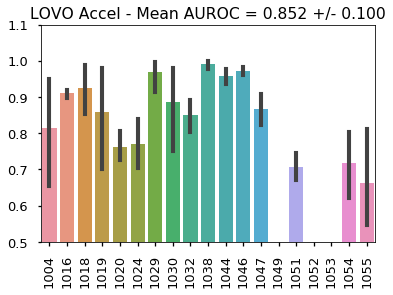

In [104]:
results = res_all.auroc.values
np.save('Results/resultsTremorLOVOAccel.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    tremor_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.5,1.1])

plt.savefig('Results/resultsTremorLOVOAccel.png',format='png',dpi=1000)

In [105]:
#LOVO Combined Tremor

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

Subject 1004
Training Random Forest

Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.684


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.850
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan

Subj/Visit 6,prec=0.000,rec=0.000,Spec=0.972,auroc_train=1.000,auroc=0.713
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.431+/-0.301, auroc=0.749+/-0.072
Subject 1016
Training Random Forest

Subj/Visit 0,prec=0.802,rec=0.762,Spec=0.815,auroc_train=1.000,auroc=0.865

Subj/Visit 1,prec=0.912,rec=0.820,Spec=0.893,auroc_train=1.000,auroc=0.936

Subj/Visit 2,prec=0.900,rec=0.800,Spec=0.907,auroc_train=1.000,auroc=0.918

Subj/Visit 3,prec=0.903,rec=0.783,Spec=0.900,auroc_train=1.000,auroc=0.934

Subj/Visit 4,prec=0.899,rec=0.892,Spec=0.873,auroc_train=1.000,auroc=0.947

Subj/Visit 5,prec=0.929,rec=0.755,Spec=0.917,auroc_train=1.000,auroc=0.904


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6,prec=0.000,rec=0.000,Spec=0.496,auroc_train=1.000,auroc=nan
f1_test=0.723+/-0.297, prec=0.763+/-0.314, rec=0.688+/-0.284, auprc=0.920+/-0.031, auroc=0.917+/-0.027
Subject 1018
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.860

Subj/Visit 1,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 2,prec=1.000,rec=0.429,Spec=1.000,auroc_train=1.000,auroc=0.999

Subj/Visit 3,prec=1.000,rec=0.312,Spec=1.000,auroc_train=1.000,auroc=0.878

Subj/Visit 4,prec=1.000,rec=0.250,Spec=1.000,auroc_train=1.000,auroc=0.719

Subj/Visit 5,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 6,prec=1.000,rec=0.556,Spec=1.000,auroc_train=1.000,auroc=1.000
f1_test=0.599+/-0.327, prec=0.857+/-0.350, rec=0.507+/-0.350, auprc=0.793+/-0.245, auroc=0.922+/-0.101
Subject 1019
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.549

Subj/Visit 1,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 2,prec=0.500,rec=1.000,Spec=0.994,auroc_train=1.000,auroc=0.994

Subj/Visit 3,prec=0.000,rec=0.000,Spec=0.977,auroc_train=1.000,auroc=0.932


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.995


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.940

Subj/Visit 6,prec=1.000,rec=0.100,Spec=1.000,auroc_train=1.000,auroc=0.730
f1_test=0.264+/-0.376, prec=0.357+/-0.440, rec=0.300+/-0.444, auprc=0.453+/-0.322, auroc=0.877+/-0.160
Subject 1020
Subject 1024
Training Random Forest

Subj/Visit 0,prec=0.692,rec=0.132,Spec=0.957,auroc_train=1.000,auroc=0.714

Subj/Visit 1,prec=0.000,rec=0.000,Spec=0.981,auroc_train=1.000,auroc=0.450

Subj/Visit 2,prec=0.037,rec=0.167,Spec=0.783,auroc_train=1.000,auroc=0.704

Subj/Visit 3,prec=1.000,rec=0.086,Spec=1.000,auroc_train=1.000,auroc=0.763

Subj/Visit 4,prec=0.500,rec=0.462,Spec=0.940,auroc_train=1.000,auroc=0.916
only 1 class in test data - cannot compute roc curve


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 5,prec=0.000,rec=0.000,Spec=0.922,auroc_train=1.000,auroc=nan

Subj/Visit 6,prec=0.833,rec=0.208,Spec=0.990,auroc_train=1.000,auroc=0.898
f1_test=0.179+/-0.167, prec=0.438+/-0.394, rec=0.151+/-0.146, auprc=0.466+/-0.300, auroc=0.741+/-0.154
Subject 1029
Training Random Forest

Subj/Visit 0,prec=1.000,rec=0.295,Spec=1.000,auroc_train=1.000,auroc=0.839

Subj/Visit 1,prec=0.273,rec=0.529,Spec=0.827,auroc_train=1.000,auroc=0.775

Subj/Visit 2,prec=0.123,rec=0.571,Spec=0.689,auroc_train=1.000,auroc=0.628

Subj/Visit 3,prec=0.839,rec=0.342,Spec=0.934,auroc_train=1.000,auroc=0.731

Subj/Visit 4,prec=0.636,rec=0.618,Spec=0.911,auroc_train=1.000,auroc=0.906

Subj/Visit 5,prec=0.385,rec=0.152,Spec=0.931,auroc_train=1.000,auroc=0.696

Subj/Visit 6,prec=0.722,rec=0.149,Spec=0.951,auroc_train=1.000,auroc=0.660
f1_test=0.371+/-0.148, prec=0.568+/-0.295, rec=0.379+/-0.181, auprc=0.534+/-0.285, auroc=0.748+/-0.092
Subject 1030
Training Random Forest

Subj/Visit 0,prec=1.000,rec=0.500,Spec=

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.994

Subj/Visit 3,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 4,prec=1.000,rec=0.100,Spec=1.000,auroc_train=1.000,auroc=0.980


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.981

Subj/Visit 6,prec=0.000,rec=0.000,Spec=0.984,auroc_train=1.000,auroc=0.971
f1_test=0.264+/-0.376, prec=0.429+/-0.495, rec=0.229+/-0.357, auprc=0.627+/-0.358, auroc=0.938+/-0.121
Subject 1032
Training Random Forest

Subj/Visit 0,prec=0.000,rec=0.000,Spec=0.994,auroc_train=1.000,auroc=0.859

Subj/Visit 1,prec=1.000,rec=0.417,Spec=1.000,auroc_train=1.000,auroc=0.890

Subj/Visit 2,prec=1.000,rec=0.600,Spec=1.000,auroc_train=1.000,auroc=0.994


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.500

Subj/Visit 4,prec=0.286,rec=1.000,Spec=0.970,auroc_train=1.000,auroc=0.999

Subj/Visit 5,prec=1.000,rec=1.000,Spec=1.000,auroc_train=1.000,auroc=1.000

Subj/Visit 6,prec=0.000,rec=0.000,Spec=0.996,auroc_train=1.000,auroc=0.960
f1_test=0.398+/-0.378, prec=0.469+/-0.469, rec=0.431+/-0.420, auprc=0.588+/-0.359, auroc=0.886+/-0.166
Subject 1038
Training Random Forest

Subj/Visit 0,prec=0.830,rec=0.629,Spec=0.871,auroc_train=1.000,auroc=0.872

Subj/Visit 1,prec=0.630,rec=0.723,Spec=0.796,auroc_train=1.000,auroc=0.802

Subj/Visit 2,prec=0.585,rec=0.689,Spec=0.718,auroc_train=1.000,auroc=0.809

Subj/Visit 3,prec=0.804,rec=0.569,Spec=0.844,auroc_train=1.000,auroc=0.728

Subj/Visit 4,prec=0.852,rec=0.590,Spec=0.931,auroc_train=1.000,auroc=0.898

Subj/Visit 5,prec=0.648,rec=0.761,Spec=0.762,auroc_train=1.000,auroc=0.892

Subj/Visit 6,prec=0.705,rec=0.596,Spec=0.827,auroc_train=1.000,auroc=0.798
f1_test=0.676+/-0.028, pr

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan

Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.979


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.150+/-0.128, auroc=0.934+/-0.044
Subject 1049
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 0,prec=0.807,rec=0.523,Spec=0.904,auroc_train=1.000,auroc=0.750

Subj/Visit 1,prec=0.951,rec=0.591,Spec=0.964,auroc_train=1.000,auroc=0.847

Subj/Visit 2,prec=0.974,rec=0.673,Spec=0.955,auroc_train=1.000,auroc=0.936

Subj/Visit 3,prec=0.522,rec=0.462,Spec=0.928,auroc_train=1.000,auroc=0.809

Subj/Visit 4,prec=0.533,rec=0.500,Spec=0.909,auroc_train=1.000,auroc=0.826

Subj/Visit 5,prec=0.821,rec=0.464,Spec=0.943,auroc_train=1.000,auroc=0.776

Subj/Visit 6,prec=0.810,rec=0.468,Spec=0.859,auroc_train=1.000,auroc=0.769
f1_test=0.622+/-0.102, prec=0.774+/-0.168, rec=0.526+/-0.074, auprc=0.749+/-0.152, auroc=0.816+/-0.058
Subject 1051
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda

only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.674


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan

Subj/Visit 3,prec=1.000,rec=0.148,Spec=1.000,auroc_train=1.000,auroc=0.573


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\

only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.043+/-0.096, prec=0.167+/-0.373, rec=0.025+/-0.055, auprc=0.406+/-0.099, auroc=0.624+/-0.051
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1054
Training Random Forest
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:91: Runti

only 1 class in test data - cannot compute roc curve

Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest

Subj/Visit 0,prec=0.929,rec=1.000,Spec=0.000,auroc_train=1.000,auroc=0.555

Subj/Visit 1,prec=0.650,rec=0.823,Spec=0.054,auroc_train=1.000,auroc=0.352

Subj/Visit 2,prec=0.548,rec=0.895,Spec=0.097,auroc_train=1.000,auroc=0.524

Subj/Visit 3,prec=0.955,rec=0.875,Spec=0.667,auroc_train=1.000,auroc=0.896

Subj/Visit 4,prec=0.775,rec=0.972,Spec=0.130,auroc_train=1.000,auroc=0.831

Subj/Visit 5,prec=0.979,rec=0.896,Spec=0.000,auroc_train=1.000,auroc=0.741
f1_test=0.847+/-0.107, prec=0.806+/-0.163, rec=0.910+/-0.059, auprc=0.842+/-0.173, auroc=0.650+/-0.189
Subject 1056
Training Random Forest

Subj/Visit 0,prec=0

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5,prec=0.909,rec=0.982,Spec=0.000,auroc_train=1.000,auroc=0.318
f1_test=0.798+/-0.223, prec=0.741+/-0.296, rec=0.962+/-0.038, auprc=0.766+/-0.259, auroc=0.541+/-0.178


C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


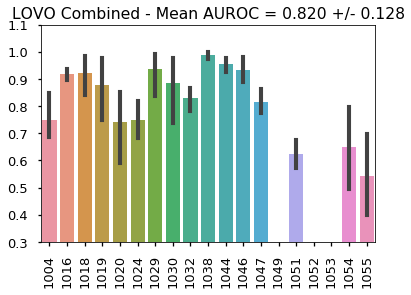

In [106]:
results = res_all.auroc.values
np.save('Results/resultsTremorLOVOCombined.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    tremor_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.3,1.1])

plt.savefig('Results/resultsTremorLOVOCombined.png',format='png',dpi=1000)

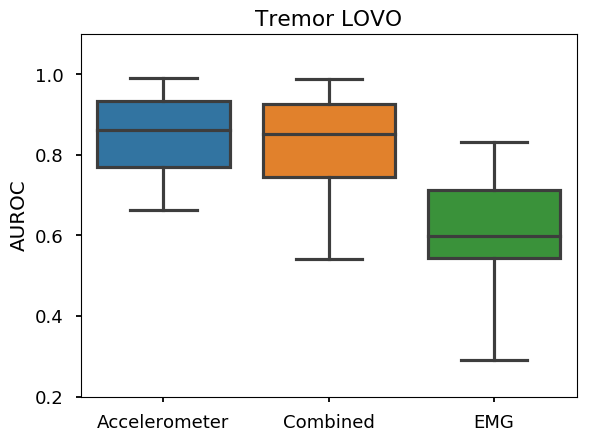

In [110]:
resultsEMG = np.load('Results/resultsTremorLOVOEMG.npy')
resultsAccel = np.load('Results/resultsTremorLOVOAccel.npy')
resultsCombined = np.load('Results/resultsTremorLOVOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.2,1.1);
plt.title('Tremor LOVO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOVO.png',format='png',dpi=1000)

### Bradykinesia

In [112]:
#LOVO EMG Bradykinesia

symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:94]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

Subject 1004
Training Random Forest

Subj/Visit 0,prec=0.909,rec=0.120,Spec=0.933,auroc_train=1.000,auroc=0.564

Subj/Visit 1,prec=0.100,rec=0.091,Spec=0.793,auroc_train=1.000,auroc=0.386

Subj/Visit 2,prec=0.231,rec=0.333,Spec=0.868,auroc_train=1.000,auroc=0.639

Subj/Visit 3,prec=0.350,rec=0.175,Spec=0.755,auroc_train=1.000,auroc=0.398

Subj/Visit 4,prec=0.333,rec=0.188,Spec=0.912,auroc_train=1.000,auroc=0.577

Subj/Visit 5,prec=0.111,rec=0.036,Spec=0.890,auroc_train=1.000,auroc=0.680

Subj/Visit 6,prec=0.077,rec=0.065,Spec=0.619,auroc_train=1.000,auroc=0.332
f1_test=0.168+/-0.085, prec=0.302+/-0.269, rec=0.144+/-0.093, auprc=0.365+/-0.220, auroc=0.511+/-0.127
Subject 1016
Training Random Forest

Subj/Visit 0,prec=0.961,rec=0.985,Spec=0.000,auroc_train=1.000,auroc=0.300

Subj/Visit 1,prec=0.927,rec=1.000,Spec=0.000,auroc_train=1.000,auroc=0.749

Subj/Visit 2,prec=0.912,rec=1.000,Spec=0.000,auroc_train=1.000,auroc=0.766

Subj/Visit 3,prec=0.981,rec=0.963,Spec=0.000,auroc_train=1.000,a

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less

only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=0.954,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=0.980,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn


Subj/Visit 3,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.599
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=0.971,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\met

only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.464+/-0.010, auroc=0.642+/-0.043
Subject 1049
Training Random Forest

Subj/Visit 0,prec=0.239,rec=0.423,Spec=0.402,auroc_train=1.000,auroc=0.406

Subj/Visit 1,prec=0.906,rec=0.707,Spec=0.500,auroc_train=1.000,auroc=0.680

Subj/Visit 2,prec=0.857,rec=0.387,Spec=0.333,auroc_train=1.000,auroc=0.367

Subj/Visit 3,prec=0.424,rec=0.622,Spec=0.604,auroc_train=1.000,auroc=0.707

Subj/Visit 4,prec=0.585,rec=0.544,Spec=0.758,auroc_train=1.000,auroc=0.706

Subj/Visit 5,prec=0.711,rec=0.651,Spec=0.728,auroc_train=1.000,auroc=0.783

Subj/Visit 6,prec=0.513,rec=0.513,Spec=0.565,auroc_train=1.000,auroc=0.533
f1_test=0.556+/-0.141, prec=0.605+/-0.221, rec=0.550+/-0.110, auprc=0.614+/-0.234, auroc=0.598+/-0.151
Subject 1051
Training Random Forest

Subj/Visit 0,prec=0.765,rec=0.342,Spec=0.929,auroc_train=1.000

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.253

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.765

Subj/Visit 3,prec=1.000,rec=0.268,Spec=1.000,auroc_train=1.000,auroc=0.719

Subj/Visit 4,prec=0.000,rec=0.000,Spec=0.927,auroc_train=1.000,auroc=0.606

Subj/Visit 5,prec=0.000,rec=0.000,Spec=0.989,auroc_train=1.000,auroc=0.554


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=0.699
f1_test=0.128+/-0.203, prec=0.252+/-0.404, rec=0.087+/-0.139, auprc=0.264+/-0.262, auroc=0.606+/-0.159
Subject 1052
Training Random Forest

Subj/Visit 0,prec=0.850,rec=0.555,Spec=0.514,auroc_train=1.000,auroc=0.572

Subj/Visit 1,prec=0.704,rec=0.871,Spec=0.528,auroc_train=1.000,auroc=0.769

Subj/Visit 2,prec=0.432,rec=0.964,Spec=0.253,auroc_train=1.000,auroc=0.676

Subj/Visit 3,prec=0.843,rec=0.719,Spec=0.591,auroc_train=1.000,auroc=0.698

Subj/Visit 4,prec=0.492,rec=0.924,Spec=0.232,auroc_train=1.000,auroc=0.669

Subj/Visit 5,prec=0.675,rec=0.817,Spec=0.369,auroc_train=1.000,auroc=0.691
f1_test=0.701+/-0.069, prec=0.666+/-0.159, rec=0.808+/-0.138, auprc=0.735+/-0.140, auroc=0.679+/-0.058
Subject 1053
Training Random Forest

Subj/Visit 0,prec=0.947,rec=0.281,Spec=0.985,auroc_train=1.000,auroc=0.730

Subj/Visit 1,prec=0.643,rec=0.692,Spec=0.948,auroc_train=1.000,auroc=0.975

Subj/Visit 2,prec=0.440,rec=0.917,Spe

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


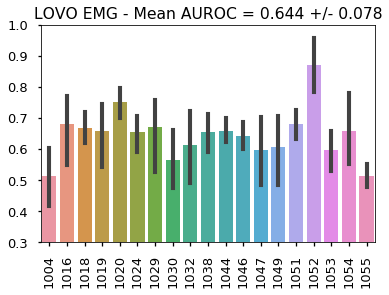

In [113]:
results = res_all.auroc.values
np.save('Results/resultsBradykinesiaLOVOEMG.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    brady_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO EMG - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.3,1.0])

plt.savefig('Results/resultsBradykinesiaLOVOEMG.png',format='png',dpi=1000)

In [114]:
#LOVO Accelerometer Bradykinesia

symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,94:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

Subject 1004
Training Random Forest

Subj/Visit 0,prec=0.846,rec=0.530,Spec=0.467,auroc_train=1.000,auroc=0.460

Subj/Visit 1,prec=0.222,rec=0.182,Spec=0.839,auroc_train=1.000,auroc=0.513

Subj/Visit 2,prec=0.615,rec=0.889,Spec=0.934,auroc_train=1.000,auroc=0.958

Subj/Visit 3,prec=0.897,rec=0.650,Spec=0.943,auroc_train=1.000,auroc=0.902

Subj/Visit 4,prec=0.500,rec=0.688,Spec=0.838,auroc_train=1.000,auroc=0.830

Subj/Visit 5,prec=0.760,rec=0.679,Spec=0.918,auroc_train=1.000,auroc=0.885

Subj/Visit 6,prec=0.536,rec=0.484,Spec=0.794,auroc_train=1.000,auroc=0.758
f1_test=0.591+/-0.179, prec=0.625+/-0.216, rec=0.586+/-0.204, auprc=0.623+/-0.228, auroc=0.758+/-0.182
Subject 1016
Training Random Forest

Subj/Visit 0,prec=0.985,rec=0.970,Spec=0.625,auroc_train=1.000,auroc=0.960

Subj/Visit 1,prec=0.990,rec=1.000,Spec=0.867,auroc_train=1.000,auroc=0.985

Subj/Visit 2,prec=0.965,rec=0.990,Spec=0.632,auroc_train=1.000,auroc=0.982

Subj/Visit 3,prec=1.000,rec=0.958,Spec=1.000,auroc_train=1.000,a

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 3,prec=1.000,rec=0.375,Spec=1.000,auroc_train=1.000,auroc=0.905
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.185+/-0.262, prec=0.333+/-0.471, rec=0.128+/-0.181, auprc=0.857+/-0.021, auroc=0.902+/-0.003
Subject 1049
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 0,prec=0.545,rec=0.692,Spec=0.744,auroc_train=1.000,auroc=0.806

Subj/Visit 1,prec=1.000,rec=0.634,Spec=1.000,auroc_train=1.000,auroc=0.932

Subj/Visit 2,prec=0.979,rec=0.758,Spec=0.833,auroc_train=1.000,auroc=0.833

Subj/Visit 3,prec=0.721,rec=0.689,Spec=0.875,auroc_train=1.000,auroc=0.844

Subj/Visit 4,prec=0.712,rec=0.737,Spec=0.813,auroc_train=1.000,auroc=0.832

Subj/Visit 5,prec=0.877,rec=0.602,Spec=0.914,auroc_train=1.000,auroc=0.850

Subj/Visit 6,prec=0.623,rec=0.632,Spec=0.659,auroc_train=1.000,auroc=0.720
f1_test=0.716+/-0.078, prec=0.780+/-0.163, rec=0.678+/-0.053, auprc=0.821+/-0.122, auroc=0.831+/-0.058
Subject 1051
Training Random Forest

Subj/Visit 0,prec=1.000,rec=0.132,Spec=1.000,auroc_train=1.000,auroc=0.809

Subj/Visit 1,prec=0.500,rec=1.000,Spec=0.979,auroc_train=1.000,auroc=1.000

Subj/Visit 2,prec=0.333,rec=0.750,Spec=0.908,auroc_train=1.000,auroc=0.950

Subj/Visit 3,prec=1.000,rec=0.049,Spec=1.000,auroc_train=1.000,auroc=0.722

Subj/Visit 4,prec=1.000,

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


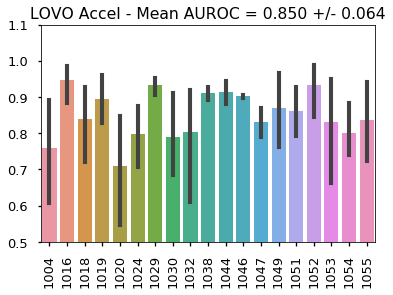

In [115]:
results = res_all.auroc.values
np.save('Results/resultsBradykinesiaLOVOAccel.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    brady_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.5,1.1])

plt.savefig('Results/resultsBradykinesiaLOVOAccel.png',format='png',dpi=1000)

In [116]:
#LOVO Combined Bradykinesia

symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

Subject 1004
Training Random Forest

Subj/Visit 0,prec=1.000,rec=0.265,Spec=1.000,auroc_train=1.000,auroc=0.719

Subj/Visit 1,prec=0.222,rec=0.091,Spec=0.920,auroc_train=1.000,auroc=0.467

Subj/Visit 2,prec=0.643,rec=1.000,Spec=0.934,auroc_train=1.000,auroc=0.997

Subj/Visit 3,prec=0.920,rec=0.575,Spec=0.962,auroc_train=1.000,auroc=0.913

Subj/Visit 4,prec=0.545,rec=0.750,Spec=0.853,auroc_train=1.000,auroc=0.878

Subj/Visit 5,prec=0.760,rec=0.679,Spec=0.918,auroc_train=1.000,auroc=0.884

Subj/Visit 6,prec=0.500,rec=0.452,Spec=0.778,auroc_train=1.000,auroc=0.735
f1_test=0.552+/-0.212, prec=0.656+/-0.246, rec=0.544+/-0.283, auprc=0.681+/-0.262, auroc=0.799+/-0.163
Subject 1016
Training Random Forest

Subj/Visit 0,prec=0.985,rec=0.980,Spec=0.625,auroc_train=1.000,auroc=0.955

Subj/Visit 1,prec=0.964,rec=1.000,Spec=0.533,auroc_train=1.000,auroc=0.991

Subj/Visit 2,prec=0.951,rec=0.995,Spec=0.474,auroc_train=1.000,auroc=0.990

Subj/Visit 3,prec=1.000,rec=0.926,Spec=1.000,auroc_train=1.000,a

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan

Subj/Visit 3,prec=1.000,rec=0.156,Spec=1.000,auroc_train=1.000,auroc=0.883
only 1 class in test data - cannot compute roc curve

Subj/Visit 4,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5,prec=0.000,rec=0.000,Spec=1.000,auroc_train=1.000,auroc=nan
f1_test=0.089+/-0.126, prec=0.333+/-0.471, rec=0.051+/-0.073, auprc=0.811+/-0.014, auroc=0.866+/-0.017
Subject 1049
Training Random Forest

Subj/Visit 0,prec=0.292,rec=0.500,Spec=0.462,auroc_train=1.000,auroc=0.511

Subj/Visit 1,prec=0.968,rec=0.744,Spec=0.833,auroc_train=1.000,auroc=0.915

Subj/Visit 2,prec=0.886,rec=0.629,Spec=0.167,auroc_train=1.000,auroc=0.362

Subj/Visit 3,prec=0.510,rec=0.578,Spec=0.740,auroc_train=1.000,auroc=0.738

Subj/Visit 4,prec=0.596,rec=0.491,Spec=0.791,auroc_train=1.000,auroc=0.715

Subj/Visit 5,prec=0.833,rec=0.723,Spec=0.852,auroc_train=1.000,auroc=0.892

Subj/Visit 6,prec=0.533,rec=0.526,Spec=0.588,auroc_train=1.000,auroc=0.525
f1_test=0.619+/-0.156, prec=0.660+/-0.225, rec=0.599+/-0.096, auprc=0.676+/-0.230, auroc=0.665+/-0.192
Subject 1051
Training Random Forest

Subj/Visit 0,prec=0.875,rec=0.368,Spec=0.964,auroc_train=1.000

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


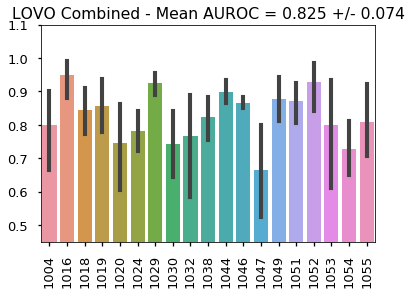

In [117]:
results = res_all.auroc.values
np.save('Results/resultsBradykinesiaLOVOCombined.npy',results)

#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    brady_auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))
    
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1.1])

plt.savefig('Results/resultsBradykinesiaLOVOCombined.png',format='png',dpi=1000)

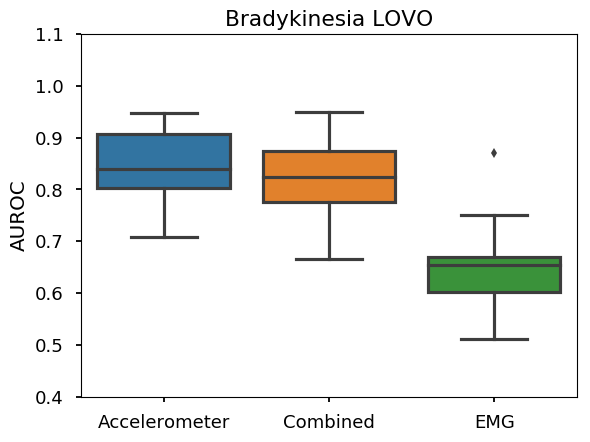

In [119]:
resultsEMG = np.load('Results/resultsBradykinesiaLOVOEMG.npy')
resultsAccel = np.load('Results/resultsBradykinesiaLOVOAccel.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOVOCombined.npy')
results = pd.DataFrame({'EMG':resultsEMG,'Accelerometer':resultsAccel,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.4,1.1);
plt.title('Bradykinesia LOVO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOVO.png',format='png',dpi=1000)

# Accelerometer and Gyroscope Comparisons

## Tremor

In [218]:
filename = 'Features_AllLocsHP_Hand.pkl'
features_path = r'Z:\CIS-PD Study\FeatureMatrix'
Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = Dataorig.reset_index(drop=True)

In [219]:
#LOSO Accelerometer Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:44].as_matrix()
fnames = Data.iloc[:,7:44].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 8937/38675 = 0.23
Training Random Forest

Subj/Visit 0,prec=0.201,rec=0.202,Spec=0.913,auroc_train=1.000,auroc=0.752

Subj/Visit 1,prec=0.635,rec=0.073,Spec=0.965,auroc_train=1.000,auroc=0.761

Subj/Visit 2,prec=0.491,rec=0.289,Spec=0.969,auroc_train=1.000,auroc=0.815

Subj/Visit 3,prec=0.133,rec=0.366,Spec=0.890,auroc_train=1.000,auroc=0.691

Subj/Visit 4,prec=0.540,rec=0.466,Spec=0.892,auroc_train=1.000,auroc=0.791

Subj/Visit 5,prec=0.388,rec=0.105,Spec=0.942,auroc_train=1.000,auroc=0.677

Subj/Visit 6,prec=0.623,rec=0.275,Spec=0.890,auroc_train=1.000,auroc=0.720

Subj/Visit 7,prec=0.600,rec=0.415,Spec=0.982,auroc_train=1.000,auroc=0.892

Subj/Visit 8,prec=0.500,rec=0.279,Spec=0.989,auroc_train=1.000,auroc=0.899

Subj/Visit 9,prec=0.948,rec=0.270,Spec=0.981,auroc_train=1.000,auroc=0.775

Subj/Visit 10,prec=0.271,rec=0.575,Spec=0.941,auroc_train=1.000,auroc=0.917

Subj/Visit 11,prec=0.255,rec=0.065,Spec=0.952,auroc_train=1.000,auroc=0.562

Subj/Visit 12,prec=0.000,rec=0

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16,prec=0.000,rec=0.000,Spec=0.975,auroc_train=1.000,auroc=nan

Subj/Visit 17,prec=0.000,rec=0.000,Spec=0.956,auroc_train=1.000,auroc=0.766

Subj/Visit 18,prec=0.907,rec=0.098,Spec=0.956,auroc_train=1.000,auroc=0.572

Subj/Visit 19,prec=0.937,rec=0.271,Spec=0.946,auroc_train=1.000,auroc=0.710
f1_test=0.254+/-0.186, prec=0.418+/-0.315, rec=0.223+/-0.179, auprc=0.412+/-0.290, auroc=0.749+/-0.094
Elapsed time = 3.479 min


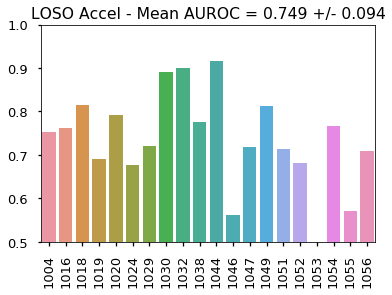

In [220]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOAccel_Hand.png',format='png',dpi=1000)

In [221]:
#LOSO Gyroscope Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,44:].as_matrix()
fnames = Data.iloc[:,44:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 8937/38675 = 0.23
Training Random Forest

Subj/Visit 0,prec=0.424,rec=0.383,Spec=0.944,auroc_train=1.000,auroc=0.799

Subj/Visit 1,prec=0.810,rec=0.094,Spec=0.982,auroc_train=1.000,auroc=0.759

Subj/Visit 2,prec=0.598,rec=0.310,Spec=0.979,auroc_train=1.000,auroc=0.800

Subj/Visit 3,prec=0.152,rec=0.312,Spec=0.920,auroc_train=1.000,auroc=0.715

Subj/Visit 4,prec=0.532,rec=0.431,Spec=0.896,auroc_train=1.000,auroc=0.796

Subj/Visit 5,prec=0.587,rec=0.096,Spec=0.976,auroc_train=1.000,auroc=0.667

Subj/Visit 6,prec=0.677,rec=0.358,Spec=0.887,auroc_train=1.000,auroc=0.749

Subj/Visit 7,prec=0.639,rec=0.317,Spec=0.988,auroc_train=1.000,auroc=0.909

Subj/Visit 8,prec=0.673,rec=0.356,Spec=0.993,auroc_train=1.000,auroc=0.887

Subj/Visit 9,prec=0.941,rec=0.312,Spec=0.976,auroc_train=1.000,auroc=0.786

Subj/Visit 10,prec=0.205,rec=0.300,Spec=0.956,auroc_train=1.000,auroc=0.869

Subj/Visit 11,prec=0.618,rec=0.299,Spec=0.953,auroc_train=1.000,auroc=0.726

Subj/Visit 12,prec=0.000,rec=0

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16,prec=0.000,rec=0.000,Spec=0.967,auroc_train=1.000,auroc=nan

Subj/Visit 17,prec=0.033,rec=0.167,Spec=0.966,auroc_train=1.000,auroc=0.898

Subj/Visit 18,prec=0.927,rec=0.186,Spec=0.936,auroc_train=1.000,auroc=0.640

Subj/Visit 19,prec=0.903,rec=0.352,Spec=0.887,auroc_train=1.000,auroc=0.703
f1_test=0.303+/-0.177, prec=0.482+/-0.317, rec=0.290+/-0.183, auprc=0.454+/-0.267, auroc=0.770+/-0.108
Elapsed time = 3.492 min


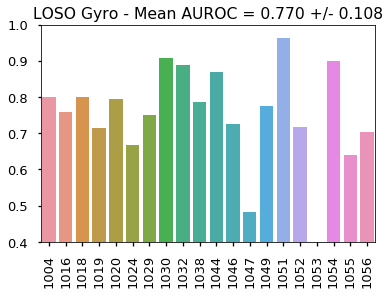

In [222]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOGyro_Hand.png',format='png',dpi=1000)

In [223]:
#LOSO Combined Tremor

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 8937/38675 = 0.23
Training Random Forest

Subj/Visit 0,prec=0.420,rec=0.394,Spec=0.941,auroc_train=1.000,auroc=0.814

Subj/Visit 1,prec=0.712,rec=0.084,Spec=0.972,auroc_train=1.000,auroc=0.765

Subj/Visit 2,prec=0.554,rec=0.246,Spec=0.980,auroc_train=1.000,auroc=0.810

Subj/Visit 3,prec=0.124,rec=0.269,Spec=0.913,auroc_train=1.000,auroc=0.714

Subj/Visit 4,prec=0.605,rec=0.448,Spec=0.920,auroc_train=1.000,auroc=0.784

Subj/Visit 5,prec=0.486,rec=0.091,Spec=0.966,auroc_train=1.000,auroc=0.682

Subj/Visit 6,prec=0.664,rec=0.358,Spec=0.880,auroc_train=1.000,auroc=0.741

Subj/Visit 7,prec=0.743,rec=0.423,Spec=0.991,auroc_train=1.000,auroc=0.903

Subj/Visit 8,prec=0.667,rec=0.346,Spec=0.993,auroc_train=1.000,auroc=0.884

Subj/Visit 9,prec=0.947,rec=0.307,Spec=0.979,auroc_train=1.000,auroc=0.780

Subj/Visit 10,prec=0.288,rec=0.525,Spec=0.951,auroc_train=1.000,auroc=0.940

Subj/Visit 11,prec=0.462,rec=0.140,Spec=0.958,auroc_train=1.000,auroc=0.656

Subj/Visit 12,prec=0.000,rec=0

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16,prec=0.000,rec=0.000,Spec=0.980,auroc_train=1.000,auroc=nan

Subj/Visit 17,prec=0.031,rec=0.167,Spec=0.964,auroc_train=1.000,auroc=0.915

Subj/Visit 18,prec=0.947,rec=0.151,Spec=0.963,auroc_train=1.000,auroc=0.600

Subj/Visit 19,prec=0.929,rec=0.320,Spec=0.927,auroc_train=1.000,auroc=0.721
f1_test=0.291+/-0.194, prec=0.474+/-0.321, rec=0.248+/-0.167, auprc=0.441+/-0.283, auroc=0.774+/-0.093
Elapsed time = 4.507 min


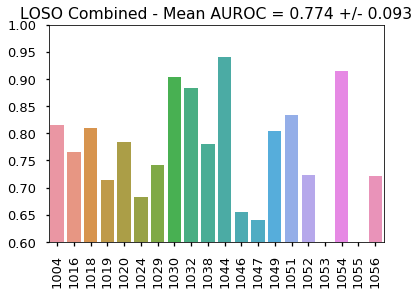

In [224]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorLOSOCombined_Hand.png',format='png',dpi=1000)

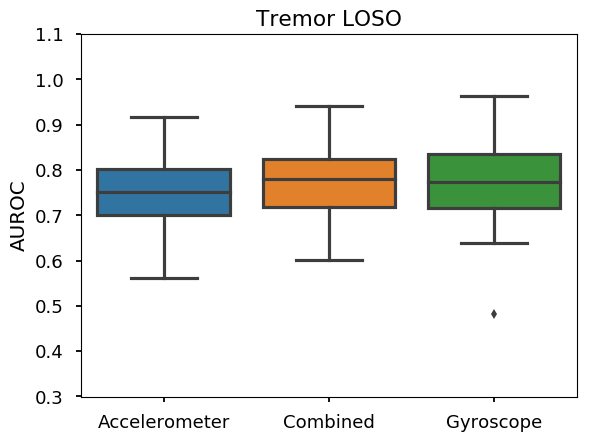

In [225]:
resultsAccel = np.load('Results/resultsTremorLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsTremorLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsTremorLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Tremor LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

## Bradykinesia

In [234]:
filename = 'Features_AllLocsHP+LP_Hand.pkl'
features_path = r'Z:\CIS-PD Study\FeatureMatrix'
Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = Dataorig.reset_index(drop=True)

In [235]:
#LOSO Accelerometer Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:44].as_matrix()
fnames = Data.iloc[:,7:44].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 16682/32592 = 0.51
Training Random Forest

Subj/Visit 0,prec=0.499,rec=0.593,Spec=0.703,auroc_train=1.000,auroc=0.710

Subj/Visit 1,prec=0.955,rec=0.711,Spec=0.639,auroc_train=1.000,auroc=0.758

Subj/Visit 2,prec=0.688,rec=0.698,Spec=0.582,auroc_train=1.000,auroc=0.707

Subj/Visit 3,prec=0.449,rec=0.904,Spec=0.557,auroc_train=1.000,auroc=0.795

Subj/Visit 4,prec=0.552,rec=0.741,Spec=0.440,auroc_train=1.000,auroc=0.628

Subj/Visit 5,prec=0.748,rec=0.565,Spec=0.681,auroc_train=1.000,auroc=0.673

Subj/Visit 6,prec=0.661,rec=0.585,Spec=0.570,auroc_train=1.000,auroc=0.579

Subj/Visit 7,prec=0.616,rec=0.734,Spec=0.573,auroc_train=1.000,auroc=0.734

Subj/Visit 8,prec=0.941,rec=0.709,Spec=0.728,auroc_train=1.000,auroc=0.794

Subj/Visit 9,prec=0.367,rec=0.659,Spec=0.559,auroc_train=1.000,auroc=0.663

Subj/Visit 10,prec=0.648,rec=0.800,Spec=0.576,auroc_train=1.000,auroc=0.756

Subj/Visit 11,prec=0.617,rec=0.679,Spec=0.696,auroc_train=1.000,auroc=0.755

Subj/Visit 12,prec=0.22

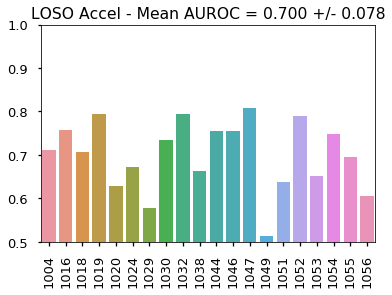

In [236]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOAccel_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.5,1.0])
plt.title('LOSO Accel - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOAccel_Hand.png',format='png',dpi=1000)

In [237]:
#LOSO Gyroscope Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,44:].as_matrix()
fnames = Data.iloc[:,44:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 8937/38675 = 0.23
Training Random Forest

Subj/Visit 0,prec=0.424,rec=0.383,Spec=0.944,auroc_train=1.000,auroc=0.799

Subj/Visit 1,prec=0.810,rec=0.094,Spec=0.982,auroc_train=1.000,auroc=0.759

Subj/Visit 2,prec=0.598,rec=0.310,Spec=0.979,auroc_train=1.000,auroc=0.800

Subj/Visit 3,prec=0.152,rec=0.312,Spec=0.920,auroc_train=1.000,auroc=0.715

Subj/Visit 4,prec=0.532,rec=0.431,Spec=0.896,auroc_train=1.000,auroc=0.796

Subj/Visit 5,prec=0.587,rec=0.096,Spec=0.976,auroc_train=1.000,auroc=0.667

Subj/Visit 6,prec=0.677,rec=0.358,Spec=0.887,auroc_train=1.000,auroc=0.749

Subj/Visit 7,prec=0.639,rec=0.317,Spec=0.988,auroc_train=1.000,auroc=0.909

Subj/Visit 8,prec=0.673,rec=0.356,Spec=0.993,auroc_train=1.000,auroc=0.887

Subj/Visit 9,prec=0.941,rec=0.312,Spec=0.976,auroc_train=1.000,auroc=0.786

Subj/Visit 10,prec=0.205,rec=0.300,Spec=0.956,auroc_train=1.000,auroc=0.869

Subj/Visit 11,prec=0.618,rec=0.299,Spec=0.953,auroc_train=1.000,auroc=0.726

Subj/Visit 12,prec=0.000,rec=0

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16,prec=0.000,rec=0.000,Spec=0.967,auroc_train=1.000,auroc=nan

Subj/Visit 17,prec=0.033,rec=0.167,Spec=0.966,auroc_train=1.000,auroc=0.898

Subj/Visit 18,prec=0.927,rec=0.186,Spec=0.936,auroc_train=1.000,auroc=0.640

Subj/Visit 19,prec=0.903,rec=0.352,Spec=0.887,auroc_train=1.000,auroc=0.703
f1_test=0.303+/-0.177, prec=0.482+/-0.317, rec=0.290+/-0.183, auprc=0.454+/-0.267, auroc=0.770+/-0.108
Elapsed time = 3.490 min


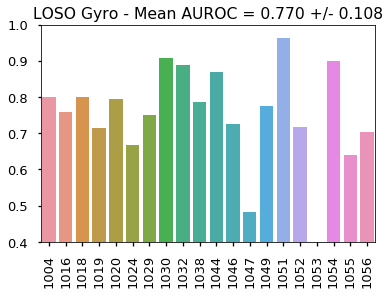

In [238]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOGyro_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.4,1.0])
plt.title('LOSO Gyro - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOGyro_Hand.png',format='png',dpi=1000)

In [239]:
#LOSO Combined Bradykinesia

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 8937/38675 = 0.23
Training Random Forest

Subj/Visit 0,prec=0.445,rec=0.388,Spec=0.948,auroc_train=1.000,auroc=0.821

Subj/Visit 1,prec=0.771,rec=0.108,Spec=0.973,auroc_train=1.000,auroc=0.801

Subj/Visit 2,prec=0.674,rec=0.332,Spec=0.984,auroc_train=1.000,auroc=0.818

Subj/Visit 3,prec=0.178,rec=0.333,Spec=0.929,auroc_train=1.000,auroc=0.722

Subj/Visit 4,prec=0.481,rec=0.431,Spec=0.873,auroc_train=1.000,auroc=0.788

Subj/Visit 5,prec=0.690,rec=0.087,Spec=0.986,auroc_train=1.000,auroc=0.682

Subj/Visit 6,prec=0.699,rec=0.380,Spec=0.891,auroc_train=1.000,auroc=0.760

Subj/Visit 7,prec=0.847,rec=0.407,Spec=0.995,auroc_train=1.000,auroc=0.919

Subj/Visit 8,prec=0.547,rec=0.337,Spec=0.989,auroc_train=1.000,auroc=0.903

Subj/Visit 9,prec=0.948,rec=0.314,Spec=0.979,auroc_train=1.000,auroc=0.802

Subj/Visit 10,prec=0.266,rec=0.362,Spec=0.962,auroc_train=1.000,auroc=0.920

Subj/Visit 11,prec=0.748,rec=0.317,Spec=0.973,auroc_train=1.000,auroc=0.728

Subj/Visit 12,prec=0.000,rec=0

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16,prec=0.000,rec=0.000,Spec=0.977,auroc_train=1.000,auroc=nan

Subj/Visit 17,prec=0.000,rec=0.000,Spec=0.974,auroc_train=1.000,auroc=0.885

Subj/Visit 18,prec=0.968,rec=0.162,Spec=0.976,auroc_train=1.000,auroc=0.639

Subj/Visit 19,prec=0.910,rec=0.348,Spec=0.897,auroc_train=1.000,auroc=0.730
f1_test=0.310+/-0.195, prec=0.506+/-0.334, rec=0.260+/-0.157, auprc=0.468+/-0.284, auroc=0.796+/-0.076
Elapsed time = 4.636 min


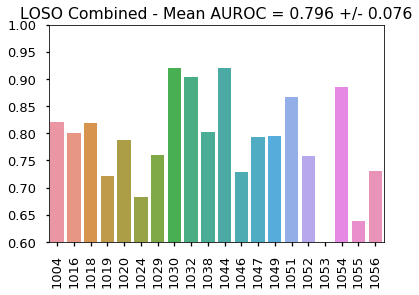

In [240]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaLOSOCombined_Hand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.60,1.0])
plt.title('LOSO Combined - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaLOSOCombined_Hand.png',format='png',dpi=1000)

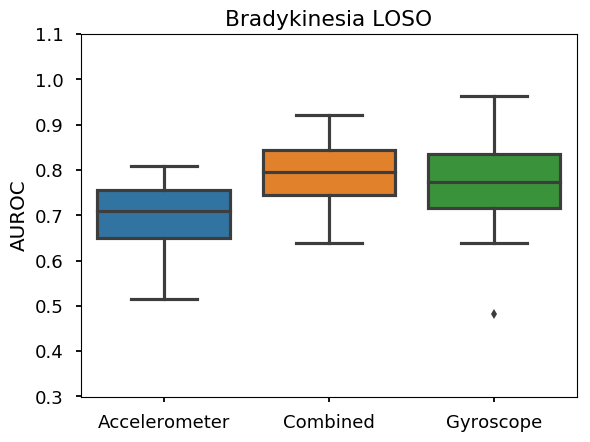

In [241]:
resultsAccel = np.load('Results/resultsBradykinesiaLOSOAccel_Hand.npy')
resultsGyro = np.load('Results/resultsBradykinesiaLOSOGyro_Hand.npy')
resultsCombined = np.load('Results/resultsBradykinesiaLOSOCombined_Hand.npy')
results = pd.DataFrame({'Accelerometer':resultsAccel,'Gyroscope':resultsGyro,'Combined':resultsCombined})

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia LOSO');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot LOSO Hand.png',format='png',dpi=1000)

# Smartwatch Comparisons

## Tremor

In [242]:
#Hand Sensors

filename = 'Features_AllLocsHP_Hand.pkl'
features_path = r'Z:\CIS-PD Study\FeatureMatrix'

Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:44]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1016) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1018) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1019) & (Dataorig.Side=='left') | 
                       #(Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1029) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1030) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1032) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1038) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1044) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1046) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1049) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1051) & (Dataorig.Side=='left')]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 3911/14447 = 0.27
Training Random Forest

Subj/Visit 0,prec=0.163,rec=0.256,Spec=0.856,auroc_train=1.000,auroc=0.680

Subj/Visit 1,prec=0.639,rec=0.134,Spec=0.950,auroc_train=1.000,auroc=0.791

Subj/Visit 2,prec=0.589,rec=0.283,Spec=0.957,auroc_train=1.000,auroc=0.810

Subj/Visit 3,prec=0.187,rec=0.522,Spec=0.848,auroc_train=1.000,auroc=0.739

Subj/Visit 4,prec=0.403,rec=0.141,Spec=0.899,auroc_train=1.000,auroc=0.685

Subj/Visit 5,prec=0.583,rec=0.295,Spec=0.821,auroc_train=1.000,auroc=0.690

Subj/Visit 6,prec=0.679,rec=0.755,Spec=0.964,auroc_train=1.000,auroc=0.930

Subj/Visit 7,prec=0.375,rec=0.355,Spec=0.967,auroc_train=1.000,auroc=0.872

Subj/Visit 8,prec=0.939,rec=0.529,Spec=0.961,auroc_train=1.000,auroc=0.903


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.810,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.174,rec=0.021,Spec=0.927,auroc_train=1.000,auroc=0.224

Subj/Visit 11,prec=0.963,rec=0.540,Spec=0.920,auroc_train=1.000,auroc=0.864

Subj/Visit 12,prec=0.010,rec=0.167,Spec=0.897,auroc_train=1.000,auroc=0.734
f1_test=0.322+/-0.239, prec=0.439+/-0.311, rec=0.307+/-0.217, auprc=0.475+/-0.291, auroc=0.743+/-0.178
Elapsed time = 0.700 min


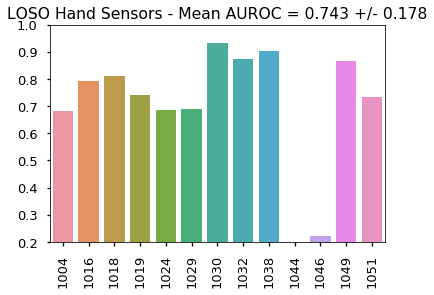

In [243]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorHand.png',format='png',dpi=1000)

In [244]:
# Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Smartwatch Data.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 3729/14025 = 0.27
Training Random Forest

Subj/Visit 0,prec=0.237,rec=0.442,Spec=0.860,auroc_train=1.000,auroc=0.713

Subj/Visit 1,prec=0.759,rec=0.179,Spec=0.967,auroc_train=1.000,auroc=0.824

Subj/Visit 2,prec=0.576,rec=0.360,Spec=0.949,auroc_train=1.000,auroc=0.849

Subj/Visit 3,prec=0.159,rec=0.277,Spec=0.901,auroc_train=1.000,auroc=0.730

Subj/Visit 4,prec=0.630,rec=0.374,Spec=0.888,auroc_train=1.000,auroc=0.775

Subj/Visit 5,prec=0.588,rec=0.389,Spec=0.795,auroc_train=1.000,auroc=0.716

Subj/Visit 6,prec=0.714,rec=0.667,Spec=0.974,auroc_train=1.000,auroc=0.978

Subj/Visit 7,prec=0.436,rec=0.708,Spec=0.953,auroc_train=1.000,auroc=0.941

Subj/Visit 8,prec=0.946,rec=0.470,Spec=0.968,auroc_train=1.000,auroc=0.875


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9,prec=0.000,rec=0.000,Spec=0.904,auroc_train=1.000,auroc=nan

Subj/Visit 10,prec=0.128,rec=0.038,Spec=0.813,auroc_train=1.000,auroc=0.211

Subj/Visit 11,prec=0.954,rec=0.501,Spec=0.916,auroc_train=1.000,auroc=0.886

Subj/Visit 12,prec=0.008,rec=0.143,Spec=0.882,auroc_train=1.000,auroc=0.853
f1_test=0.367+/-0.233, prec=0.472+/-0.323, rec=0.350+/-0.210, auprc=0.525+/-0.279, auroc=0.779+/-0.190
Elapsed time = 0.670 min


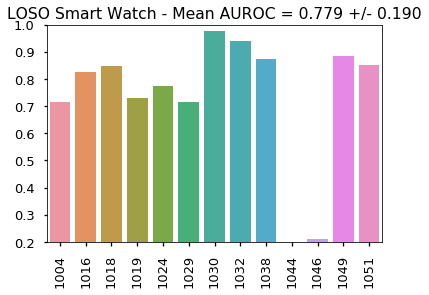

In [245]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsTremorWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsTremorWatch.png',format='png',dpi=1000)

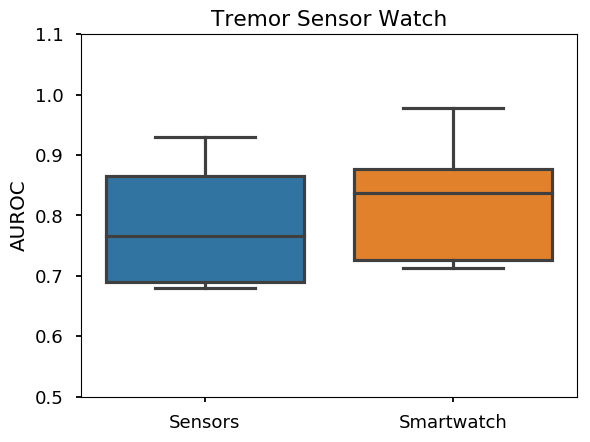

In [246]:
resultsSensor = np.load('Results/resultsTremorHand.npy')
resultsWatch = np.load('Results/resultsTremorWatch.npy')
results = pd.DataFrame({'Sensors':resultsSensor,'Smartwatch':resultsWatch})
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.5,1.1);
plt.title('Tremor Sensor Watch');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot Sensor+Watch.png',format='png',dpi=1000)

## Bradykinesia

In [146]:
#Hand Sensors

filename = 'Features_AllLocsHP+LP_Hand.pkl'
features_path = r'Z:\CIS-PD Study\FeatureMatrix'

Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:44]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1016) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1018) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1019) & (Dataorig.Side=='left') | 
                       #(Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1029) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1030) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1032) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1038) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1044) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1046) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1049) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1051) & (Dataorig.Side=='left')]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 6504/11863 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.382,rec=0.728,Spec=0.562,auroc_train=1.000,auroc=0.689

Subj/Visit 1,prec=0.937,rec=0.692,Spec=0.726,auroc_train=1.000,auroc=0.792

Subj/Visit 2,prec=0.927,rec=0.790,Spec=0.664,auroc_train=1.000,auroc=0.776

Subj/Visit 3,prec=0.625,rec=0.945,Spec=0.326,auroc_train=1.000,auroc=0.658

Subj/Visit 4,prec=0.781,rec=0.650,Spec=0.722,auroc_train=1.000,auroc=0.749

Subj/Visit 5,prec=0.666,rec=0.600,Spec=0.598,auroc_train=1.000,auroc=0.610

Subj/Visit 6,prec=0.748,rec=0.901,Spec=0.437,auroc_train=1.000,auroc=0.764

Subj/Visit 7,prec=0.916,rec=0.712,Spec=0.762,auroc_train=1.000,auroc=0.803

Subj/Visit 8,prec=0.080,rec=0.468,Spec=0.530,auroc_train=1.000,auroc=0.508

Subj/Visit 9,prec=0.073,rec=0.936,Spec=0.353,auroc_train=1.000,auroc=0.713

Subj/Visit 10,prec=0.534,rec=0.471,Spec=0.501,auroc_train=1.000,auroc=0.483

Subj/Visit 11,prec=0.893,rec=0.501,Spec=0.567,auroc_train=1.000,auroc=0.553

Subj/Visit 12,prec=0.378

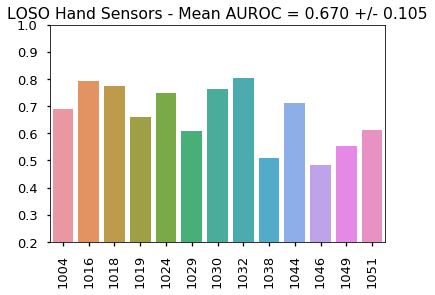

In [140]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaHand.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Hand Sensors - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaHand.png',format='png',dpi=1000)

In [147]:
#Smart Watch

Dataorig = pd.read_csv('Z:CIS-PD Study\\Smartwatch Data.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 5839/10580 = 0.55
Training Random Forest

Subj/Visit 0,prec=0.401,rec=0.534,Spec=0.649,auroc_train=1.000,auroc=0.604

Subj/Visit 1,prec=0.936,rec=0.685,Spec=0.742,auroc_train=1.000,auroc=0.800

Subj/Visit 2,prec=0.927,rec=0.710,Spec=0.709,auroc_train=1.000,auroc=0.724

Subj/Visit 3,prec=0.649,rec=0.854,Spec=0.322,auroc_train=1.000,auroc=0.600

Subj/Visit 4,prec=0.721,rec=0.849,Spec=0.503,auroc_train=1.000,auroc=0.753

Subj/Visit 5,prec=0.652,rec=0.584,Spec=0.589,auroc_train=1.000,auroc=0.602

Subj/Visit 6,prec=0.657,rec=0.944,Spec=0.352,auroc_train=1.000,auroc=0.673

Subj/Visit 7,prec=0.825,rec=0.721,Spec=0.459,auroc_train=1.000,auroc=0.603

Subj/Visit 8,prec=0.069,rec=0.661,Spec=0.326,auroc_train=1.000,auroc=0.496

Subj/Visit 9,prec=0.080,rec=0.959,Spec=0.343,auroc_train=1.000,auroc=0.747

Subj/Visit 10,prec=0.510,rec=0.371,Spec=0.591,auroc_train=1.000,auroc=0.433

Subj/Visit 11,prec=0.921,rec=0.476,Spec=0.407,auroc_train=1.000,auroc=0.400

Subj/Visit 12,prec=0.390

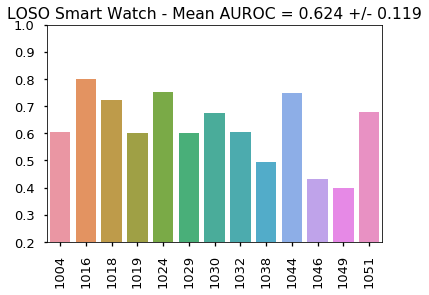

In [142]:
results = res_group['Random Forest']['auroc']
np.save('Results/resultsBradykinesiaWatch.npy',results)
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall)
ax = plt.xticks(rotation=90)
plt.ylim([0.2,1.0])
plt.title('LOSO Smart Watch - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))
plt.savefig('Results/resultsBradykinesiaWatch.png',format='png',dpi=1000)

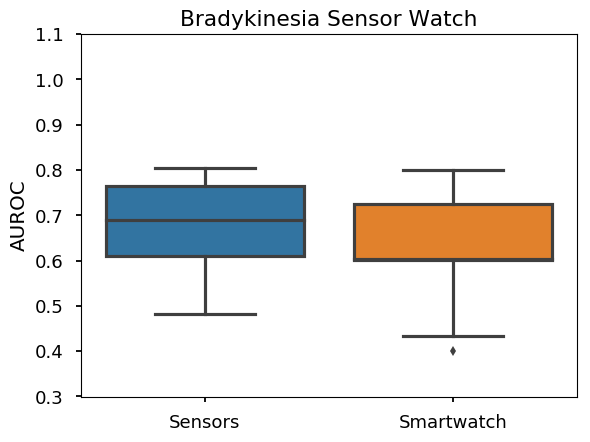

In [151]:
resultsSensor = np.load('Results/resultsBradykinesiaHand.npy')
resultsWatch = np.load('Results/resultsBradykinesiaWatch.npy')
results = pd.DataFrame({'Sensors':resultsSensor,'Smartwatch':resultsWatch})
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=results);
plt.ylabel('AUROC');
plt.ylim(0.3,1.1);
plt.title('Bradykinesia Sensor Watch');

#x1,x2 = 0,1
#y, h, col = results['Accelerometer'].max() + 0.02, 0.02, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot Sensor+Watch.png',format='png',dpi=1000)

# Data Loss Comparisons

In [10]:
full_dict = {}
count = 0
subj_list = ([1004,1016,1018,1019,1020,1024,1029,1030,1032,1038,1044,1046,1047,1049,1051,1052,1053,1054,1055,1056])
for subj in subj_list:
    f = open('Z:\CIS-PD Study\Data_dict\\' + str(subj) + 'dict.pkl', 'rb')
    full_dict[subj] = (pickle.load(f))
    f.close()
    count = count + 1
    if count < 10:
        print(' ' + str(count) + ' of 20 subjects loaded')
    else:
        print(str(count) + ' of 20 subjects loaded')

 1 of 20 subjects loaded
 2 of 20 subjects loaded
 3 of 20 subjects loaded
 4 of 20 subjects loaded
 5 of 20 subjects loaded
 6 of 20 subjects loaded
 7 of 20 subjects loaded
 8 of 20 subjects loaded
 9 of 20 subjects loaded
10 of 20 subjects loaded
11 of 20 subjects loaded
12 of 20 subjects loaded
13 of 20 subjects loaded
14 of 20 subjects loaded
15 of 20 subjects loaded
16 of 20 subjects loaded
17 of 20 subjects loaded
18 of 20 subjects loaded
19 of 20 subjects loaded
20 of 20 subjects loaded


In [ ]:
sensor_clip_len = pd.DataFrame()
